## 1. Definition of computational parameters

In [3]:
import os
import sys
import shutil
import re
import math
import nglview as nv
import pytraj as pt

#insert path to python scripts
sys.path.insert(1, os.environ['BASE'] + "/modules")

from draw_2d import *
from draw_3d import drawit
from tqdm.notebook import tqdm

from molvs import Standardizer

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import SDWriter
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmarts
from rdkit.Chem import rdmolops
from rdkit.Chem import rdchem

from convert import *

In [4]:
#define parameters

#number of configurations to generate in basic energy minimization
numc = 50

ifilename = "molekula.txt"

#use podman
#gromacs_s = "/opt/podman-run.py gromacs -p" #gmx_mpi
#gromacs_d = "/opt/podman-run.py gromacs -p -d" #double precision gromacs

#use docker
gromacs_s = "/opt/gmx-docker" #gmx_mpi
gromacs_d = "/opt/gmx-docker -d" #double precision gromacs

orca = "/opt/podman-run.py orca -p"
plumed = gromacs_s

#specify number of abailable cpu's to be used in evaluations (maximum possible on machine by default)
num_of_cpus = os.environ['CPUS']

## 2. Molecule shape processing

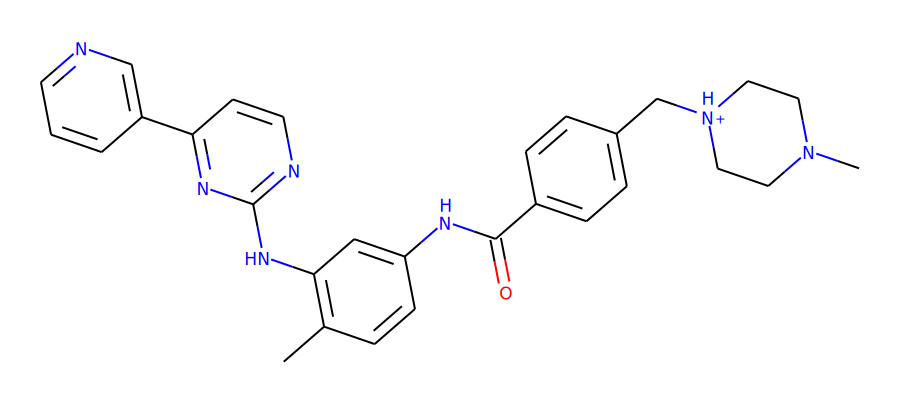

In [5]:
with open(ifilename, "r") as ifile:
    molecule = ifile.readlines()
smiles_molecule = str.split(molecule[0])[0]

molecule = Chem.MolFromSmiles(smiles_molecule)

render_svg(moltosvg(molecule))

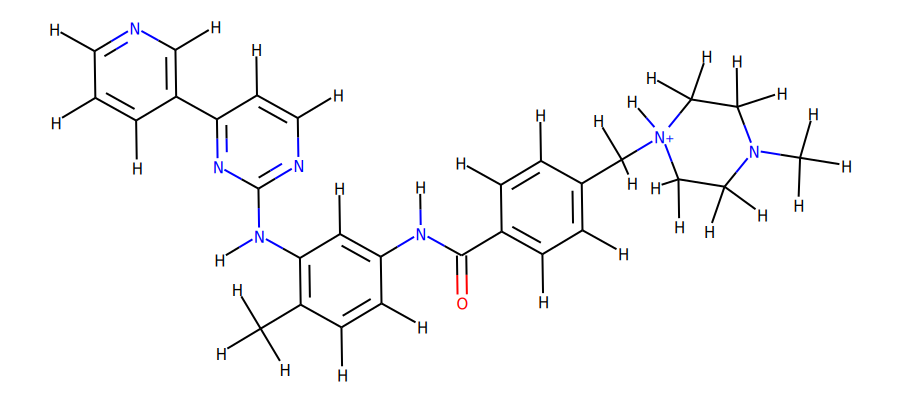

In [6]:
with open("molekula.smi", "w") as smifile:
    smifile.write(smiles_molecule)
    
s = Standardizer()
molecule = s.standardize(molecule)
molecule = Chem.AddHs(molecule)
natoms = molecule.GetNumAtoms()

render_svg(moltosvg(molecule))

In [7]:
#set lowest energy configuration

#set default id of minimal energy conformer to -1
minid = -1
#set default minimal energy to highest possible float number
minene = sys.float_info.max

AllChem.EmbedMultipleConfs(molecule, clearConfs=True, numConfs=numc)
#run 'MMFF94 force field' energy evaluation
done = AllChem.MMFFOptimizeMoleculeConfs(molecule)

for i in range(len(done)):
    if done[i][1]<minene:
        minene = done[i][1]
        minid = i
print(f'Minimal energy: {minene}')

writer = SDWriter("molekula.mol")
writer.write(molecule, confId=minid)

drawit(molecule)

Minimal energy: 78.80308914244146


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
#set pattern to detect torsion angles

RotatableBond = Chem.MolFromSmarts('[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]-&!@[!$([NH]!@C(=O))&!D1&!$(*#*)&!$([C;H3])&!$([O;H1])&!$([N;H3])]')
rotatables = molecule.GetSubstructMatches(RotatableBond)
print(rotatables)

((2, 24), (8, 10), (13, 16), (16, 17), (24, 25), (29, 31))


In [9]:
#get numbers of atoms that form torsion angles

torsions = []
for rotatable in rotatables:
    pairs1 = []
    pairs2 = []
    for bond in molecule.GetBonds():
        if rotatable[0]==bond.GetBeginAtomIdx() and rotatable[1]!=bond.GetEndAtomIdx():
            pairs1.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
        if rotatable[1]==bond.GetBeginAtomIdx() and rotatable[0]!=bond.GetEndAtomIdx():
            pairs2.append([bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()])
    torsions.append([pairs1[0][1],pairs1[0][0],pairs2[0][0],pairs2[0][1]])
print(torsions)

[[3, 2, 24, 25], [9, 8, 10, 11], [14, 13, 16, 17], [48, 16, 17, 18], [62, 24, 25, 26], [30, 29, 31, 32]]


## 3. Preparation of environment and molecule

In [10]:
# prepare input files for energetic minimization

netcharge = rdmolops.GetFormalCharge(molecule)
!antechamber -i molekula.mol -fi mdl -o molekula.prepi -fo prepi -c bcc -nc {netcharge} && \
parmchk2 -i molekula.prepi -f prepi -o molekula.frcmod && \
tleap -f tleapin.txt && \
acpype -p molekula.prmtop -x molekula.inpcrd


Welcome to antechamber 19.0: molecular input file processor.

acdoctor mode is on: check and diagnose problems in the input file.
-- Check Format for mdl File --
   Status: pass
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Info: Total number of electrons: 262; net charge: 1

Running: /opt/intelpython3/bin/sqm -O -i sqm.in -o sqm.out

-I: Adding /opt/intelpython3/dat/leap/prep to search path.
-I: Adding /opt/intelpython3/dat/leap/lib to search path.
-I: Adding /opt/intelpython3/dat/leap/parm to search path.
-I: Adding /opt/intelpython3/dat/leap/cmd to search path.
-f: Source tleapin.txt.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleapin.txt
----- Source: /opt/intelpython3/dat/leap/cmd/leaprc.gaff
----- 

In [11]:
#fix ordering of atoms

order_before = []
order_after = []

with open('sqm.pdb','r') as pdbfile:
    for atom in pdbfile.readlines():
        order_before.append(atom.split()[2])
        
with open('MOL_GMX.gro','r') as grofile:
    for atom in grofile.readlines():
        if atom.startswith('    1  MOL'):
            order_after.append(atom.split()[2])

torsions_new = []
torsion_new = []
for torsion in torsions:
    for i in torsion:       
        torsion_new.append(order_after.index(order_before[i])+1)
    torsions_new.append(torsion_new)
    torsion_new = []
torsions = torsions_new
print(torsions)

[[22, 21, 19, 18], [37, 36, 38, 43], [40, 47, 48, 51], [49, 48, 51, 53], [20, 19, 18, 17], [12, 11, 10, 8]]


In [12]:
!mkdir em
with open("em/em.mdp", "w") as emfile:
    emfile.write("integrator          =  steep\n")
    emfile.write("nsteps              =  100000\n")
    emfile.write("emtol               =  0\n")
    emfile.write("emstep              =  0.1\n")
    emfile.write("nstcomm             =  1\n")
    emfile.write("nstxout             =  100\n")
    emfile.write("nstvout             =  100\n")
    emfile.write("nstfout             =  0\n")
    emfile.write("nstlog              =  100\n")
    emfile.write("nstenergy           =  100\n")
    emfile.write("nstlist             =  1\n")
    emfile.write("ns_type             =  grid\n")
    emfile.write("coulombtype         =  cut-off\n")
    emfile.write("rlist               =  1.4\n")
    emfile.write("rcoulomb            =  1.4\n")
    emfile.write("rvdw                =  1.4\n")
    emfile.write("energygrps          =  System\n")
    emfile.write("epsilon-r           =  80\n")
    emfile.write("\n")
shutil.copy("MOL_GMX.gro", "em/")
shutil.copy("MOL_GMX.top", "em/")

mkdir: cannot create directory 'em': File exists


'em/MOL_GMX.top'

In [14]:
!{gromacs_s} -w /em -- editconf -f MOL_GMX -o box -c -box 3 3 3 && \
{gromacs_s} -w /em -- grompp -f em.mdp -c box -p MOL_GMX -o em1 && \
{gromacs_d} -w /em -- mdrun -deffnm em1 -ntomp 2 


                     :-) GROMACS - gmx editconf, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, 

The current CPU can measure timings more accurately than the code in
gmx mdrun was configured to use. This might affect your simulation
speed as accurate timings are needed for load-balancing.
Please consider rebuilding gmx mdrun with the GMX_USE_RDTSCP=ON CMake option.
Reading file em1.tpr, VERSION 2019.4 (single precision)

Using 1 MPI process
Using 2 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  0.00000e+00
   Number of steps    =       100000

Energy minimization reached the maximum number of steps before the forces
reached the requested precision Fmax < 0.

writing lowest energy coordinates.

Steepest Descents did not converge to Fmax < 0 in 100001 steps.
Potential Energy  =  1.23367224190550e+02
Maximum force     =  5.05815167739802e-01 on atom 36
Norm of force     =  1.29577944272449e-01

GROMACS reminds you: "I'm Looking for a New Simulation" (Stone Temple Pilots)



In [15]:
#prepare files for getting the molecule to dynamic state

!mkdir md
with open("md/md.mdp", "w") as mdfile:
    mdfile.write("integrator          = sd\n")
    mdfile.write("nsteps              = 100000\n")
    mdfile.write("dt                  = 0.001\n")
    mdfile.write("nstxout             = 1000\n")
    mdfile.write("nstvout             = 1000\n")
    mdfile.write("nstenergy           = 1000\n")
    mdfile.write("nstlog              = 1000\n")
    mdfile.write("continuation        = no\n")
    mdfile.write("constraints         = none\n")
    mdfile.write("cutoff-scheme       = Verlet\n")
    mdfile.write("ns_type             = grid\n")
    mdfile.write("nstlist             = 1\n")
    mdfile.write("rlist               = 1.4\n")
    mdfile.write("rcoulomb            = 1.4\n")
    mdfile.write("rvdw                = 1.4\n")
    mdfile.write("coulombtype         = cut-off\n")
    mdfile.write("tcoupl              = V-rescale\n")
    mdfile.write("tc-grps             = system\n")
    mdfile.write("tau_t               = 0.1\n")
    mdfile.write("ref_t               = 300\n")
    mdfile.write("pcoupl              = no\n")
    mdfile.write("pbc                 = xyz\n")
    mdfile.write("gen_vel             = yes\n")
    mdfile.write("epsilon-r           = 80\n")
    mdfile.write("\n")
shutil.copy("em/em1.gro", "md/")
shutil.copy("MOL_GMX.top", "md/")

'md/MOL_GMX.top'

In [16]:
!{gromacs_s} -w /md -- grompp -f md.mdp -c em1 -p MOL_GMX -o md1 && \
{gromacs_d} -w /md -- mdrun -deffnm md1 -ntomp 2


                      :-) GROMACS - gmx grompp, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, B

In [28]:
#show trajectory of conformations
#select group for trjconv evaluation
#Group     0 (         System)
#Group     1 (          Other)
#Group     2 (            MOL)
group = 0

!{gromacs_s} -i {group} -w /md -- trjconv -s md1.tpr -f md1.trr -o outTraj.pdb

traj = pt.load('md/outTraj.pdb')
view = nv.show_pytraj(traj)
view


Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
                     :-) GROMACS - gmx trjconv, 2019.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent

NGLWidget(max_frame=100)

In [ ]:
#fix periodic boundaries errors when the molecule jumps out of the box
#select group for trjconv evaluation
#Group     0 (         System)
#Group     1 (          Other)
#Group     2 (            MOL)
group = 1

for i in tqdm(range(len(torsions))):
  fr = str(float(100-len(torsions)+i)-0.01)
  to = str(float(100-len(torsions)+i)+0.01)
  !{gromacs_s} -i {group} -w /md -- trjconv -pbc nojump -s md1 -f md1 -o frame{i}.gro -b {fr} -e {to}<<EOF\n0\nEOF

## 4. Generation of representative configurations
### 4.1 Trajectory generation

In [ ]:
!mkdir mtd
with open("mtd/mtd.mdp", "w") as mtdfile:
    mtdfile.write("integrator          = sd\n")
    mtdfile.write("nsteps              = 10000000\n") #10 ns each replica
    mtdfile.write("dt                  = 0.001\n")
    mtdfile.write("nstxout             = 10000\n") # output coordinates every 10ps to *.trr
    mtdfile.write("nstvout             = 10000\n") # output velocities every 10ps to *.trr
    mtdfile.write("nstenergy           = 1000\n")
    mtdfile.write("nstlog              = 1000\n")
    mtdfile.write("continuation        = no\n")
    mtdfile.write("constraints         = none\n")
    mtdfile.write("cutoff-scheme       = Verlet\n")
    mtdfile.write("ns_type             = grid\n")
    mtdfile.write("nstlist             = 1\n")
    mtdfile.write("rlist               = 1.4\n")
    mtdfile.write("rcoulomb            = 1.4\n")
    mtdfile.write("rvdw                = 1.4\n")
    mtdfile.write("coulombtype         = cut-off\n")
    mtdfile.write("tcoupl              = V-rescale\n")
    mtdfile.write("tc-grps             = system\n")
    mtdfile.write("tau_t               = 0.1\n")
    mtdfile.write("ref_t               = 300\n")
    mtdfile.write("pcoupl              = no\n")
    mtdfile.write("pbc                 = xyz\n")
    mtdfile.write("gen_vel             = yes\n")
    mtdfile.write("epsilon-r           = 80\n")
    mtdfile.write("\n")

In [ ]:
for i in range(len(torsions)):
    if not os.path.exists("mtd/w{}".format(i)):
        !mkdir mtd/w{i}
    with open("mtd/w{}/plumed.dat".format(i), "w") as plumeddat:
        plumeddat.write("RANDOM_EXCHANGES\n")
        plumeddat.write("WHOLEMOLECULES ENTITY0=1-{}\n".format(natoms))
        for j in range(len(torsions)):
            plumeddat.write("TORSION ATOMS={},{},{},{} LABEL=cv{}\n".format(torsions[j][0],torsions[j][1],torsions[j][2],torsions[j][3],j+1))
        plumeddat.write("METAD ARG=cv{} HEIGHT=0.5 SIGMA=0.3 PACE=1000 GRID_MIN=-pi GRID_MAX=pi BIASFACTOR=15 LABEL=be\n".format(i+1))
        cvs = ""
        for j in range(len(torsions)):
            cvs=cvs+"cv{},".format(j+1)
        cvs = cvs[:-1]
        plumeddat.write("PRINT ARG={} STRIDE=1000 FILE=COLVAR\n".format(cvs))
        plumeddat.write("PRINT ARG=be.bias STRIDE=1000 FILE=BIAS\n")

shutil.copy("MOL_GMX.top", "mtd/")

In [ ]:
for i in tqdm(range(len(torsions))):
    shutil.copy("md/frame{}.gro".format(i), "mtd/w{}/".format(i))
    !{gromacs_s} -w /mtd -- grompp -f mtd.mdp -c w{i}/frame{i} -p MOL_GMX -o w{i}/mtd1

In [ ]:
directories = ""
for i in range(len(torsions)):
    directories = directories + "w{} ".format(i)

!{gromacs_d} -n {len(torsions)} -w /mtd -- mdrun -ntomp 1 -deffnm mtd1 -replex 500 -plumed plumed.dat -multidir {directories}

### 4.2 Configurations clustering

In [ ]:
#select groups for cluster evaluation
#Group     0 (         System)
#Group     1 (          Other)
#Group     2 (            MOL)
groups = "30"

trajectories = ""
for i in range(len(torsions)):
    trajectories = trajectories + "mtd/w{}/mtd1.trr ".format(i)

#concatinate trajectories    
!{gromacs_s} trjcat -f {trajectories} -cat -o mtd/mtd1.trr
#make index file with non-hydrogen atoms, use 1 & ! a H* and q for input
!{gromacs_s} -m "'1&!aH*_q'" -- make_ndx -f md/md1.tpr -o mtd/index.ndx
#include index file and select index group 3
!{gromacs_s} -i {groups} -- cluster -method gromos -f mtd/mtd1.trr -s mtd/w0/mtd1.tpr -n mtd/index.ndx -cutoff 0.15 -cl clustering/outCluster.pdb


#divide all clusters from gmx cluster to single clusters
with open("clustering/outCluster.pdb") as input_cluster:
    i = 0
    outFile = open("clustering/outClustersPDB/outCluster{}.pdb".format(i), "w")
    for line in input_cluster:
        if line != "ENDMDL\n":
            outFile.write(line)
            continue
        outFile.write("ENDMDL\n")
        i += 1
        outFile.close()
        outFile = open("clustering/outClustersPDB/outCluster{}.pdb".format(i), "w")
!rm clustering/outClustersPDB/outCluster{i}.pdb
clusters_count = i


#convert .pdb clusters to .xyz
for pdb_cluster in tqdm(os.listdir("clustering/outClustersPDB/")):
    !babel -ipdb clustering/outClustersPDB/{pdb_cluster} -oxyz clustering/outClustersXYZ/{pdb_cluster.replace("pdb", "xyz")}

## 5. Accurate and innacurate energy evaluation

In [ ]:
#orca indexes from zero

orca_torsions = [[] for _ in range(len(torsions))]
torsion_index = 0
for torsion in torsions:
    for atom_index in torsion:
        orca_torsions[torsion_index].append(atom_index - 1)
    torsion_index += 1

#Orca method description - first line in orca method
method_description = "!AM1 Opt"

convert_to_orca_methods("clustering/outClustersXYZ/", "am1/input/", orca_torsions, method_description, -1)

In [ ]:
#minimisation of conformations before quantum mechanics
input_path = "am1/input/"
output_path = "am1/output/"
method = "am1"

for orca_method in tqdm(os.listdir(input_path)):
    if not orca_method.endswith(".inp"):
        continue
    orca_method_name = orca_method.replace(".inp", "")
    orca_method_number = orca_method_name[len("outCluster"):]
    output_dir_path = output_path + orca_method_name  + "/"
    if not os.path.exists(output_dir_path):
        !mkdir output_dir_path
    shutil.copy(input_path + orca_method, output_dir_path)
    !{orca} -o orca_output{orca_method_number}.log -w /{output_dir_path} -- {orca_method}

In [ ]:
#Orca method description - first line in orca method
method_description = "!BP86 def2-TZVP TightSCF Opt"

for i in range(0, clusters_count):
    convert_to_orca_methods("am1/output/outCluster{}/".format(i), "bp86/input/", orca_torsions, method_description, num_of_cpus)

In [ ]:
#run quantum mechanics
input_path = "bp86/input/"
output_path = "bp86/output/"
method = "bp86"

for orca_method in tqdm(os.listdir(input_path)):
    if not orca_method.endswith(".inp"):
        continue
    orca_method_name = orca_method.replace(".inp", "")
    orca_method_number = orca_method_name[len("outCluster"):]
    output_dir_path = output_path + orca_method_name  + "/"
    if not os.path.exists(output_dir_path):
        !mkdir {output_dir_path
    shutil.copy(input_path + orca_method, output_dir_path)
    !{orca} -o orca_output{orca_method_number}.log -w /{output_dir_path} -- {orca_method}

In [ ]:
#extract final energies from output of orca

with open("orca_energies.txt", "a") as ofile:
    for orca_output in os.listdir("orca_output/bp86"):    
        with open("orca_output/bp86/" + orca_output) as iorca_output:
            for line in reversed(list(iorca_output)):
                energy_list = re.findall(r'(FINAL SINGLE POINT ENERGY)( +)(-?\d+\.\d+)', line)
                if len(energy_list) > 0:
                    ofile.write(energy_list[0][2])
                    ofile.write('\n')
                    break

In [ ]:
#convert from hartree to kJ/mol and write quantum mechanics energies to file

energies_in_hartree = []
with open("orca_energies.txt", "r") as ifile:
    for line in ifile.readlines():
        energies_in_hartree.append(float(line))

#constant to convert from hartree to kJ/mol
CONVERSION_CONST = 2625.499638
minimum = min(energies_in_hartree)

energies_in_kJ = []
for H in energies_in_hartree:
    energies_in_kJ.append((H-minimum)*CONVERSION_CONST)

with open("orca_energies.txt", "w") as ofile:
    for energy in energies_in_kJ:
        ofile.write("{}\n".format(energy))

In [ ]:
#copy atoms from conformation before QM and combine it with orca optimised conformations

output_dir = "pdb_opt/"
input_dir = "bp86/output/outCluster"

!mkdir {output_dir}

atoms = []
with open("clustering/outClustersPDB/outCluster0.pdb", "r") as ifile:
    for line in ifile.readlines():
        if "ATOM" in line:
            atoms.append(line[:26])
    
for i in range(0, clusters_count):
    hetatms = []
    !babel -ixyz {input_dir}{i}/outCluster{i}.xyz -opdb {output_dir}temp_cluster_{i}.pdb
    with open("{}temp_cluster_{}.pdb".format(output_dir, i), "r") as ifile:
        for line in ifile.readlines():
            if "HETATM" in line:
                hetatms.append(line[27:66])
    with open("pdb_opt/cluster{}.pdb".format(i), "w") as output_cluster:
        for i in range(len(atoms)):
            output_cluster.write(atoms[i])
            output_cluster.write(hetatms[i] + "\n")

!rm {output_dir}/temp_*

In [ ]:
input_dir = "pdb_opt/"
output_file = "clusters.pdb"

#concatinate optimised conformations to trajectory
with open(output_file, "w") as ofile:
    for i in range(0, clusters_count):
        ofile.write("MODEL {}\n".format(str(i)))
        with open("{}cluster{}.pdb".format(input_dir, i), "r") as ifile:
            ofile.write(ifile.read())
            ofile.write("ENDMDL\n")

with open("plumed.dat", "w") as ifile:
    cvs = []
    ifile.write("WHOLEMOLECULES ENTITY0=1-{}\n".format(str(clusters_count)))
    for i in range(0, len(torsions)):
        cvs.append("cv{}".format(i))
        ifile.write("TORSION ATOMS=")
        ifile.write(",".join(str(x) for x in torsions[i]))
        ifile.write(" LABEL={}\n".format(cvs[i]))
    ifile.write("PRINT ARG=")
    ifile.write(",".join(cvs))
    ifile.write(" STRIDE=1 FILE=DIHEDRALS")

#compute dihedrals
!{plumed} driver --plumed plumed.dat --mf_pdb {output_file}

lines = []
with open("DIHEDRALS", "r") as ifile:
    for line in ifile.readlines():
        if "#" not in line:
            lines.append(line)
with open("DIHEDRALS", "w") as ofile:
    for line in lines:
        ofile.write(line)

In [ ]:
#perform minimisations and compute GAFF energy

cvs = [[] for _ in range(len(torsions))]
with open("DIHEDRALS","r") as ifile:
    dihedrals = ifile.readlines()
    for i in range(len(cvs)):
        t_angles = cvs[i].split()
        for j in range(len(torsions)):
            cvs[j].append(float(t_angles[j])*(180/math.pi))

def generate_restraint(cluster_i):
    with open("MOL_GMX.top", "r") as ifile, open("gaff/cluster_{}/restrained.top".format(str(cluster_i)), "w"):
        for line in ifile.readlines():
            if line == "; Ligand position restraints\n":
                ofile.write("\n")
                ofile.write("[ dihedral_restraints ]\n")
                ofile.write(" ".join(torsions[i]))
                ofile.write("2 %3.1f 0 500\n")
                ofile.write("\n")
            ofile.write(line)
!mkdir gaff

#select groups for energy evaluation
groups = "10"

for i in range(0, clusters_count): 
    !mkdir gaff/cluster_{i}
    shutil.copy("pdb_opt/cluster{}.pdb".format(i), "gaff/cluster_{}".format(i))
    shutil.copy("MOL_GMX.top", "gaff/cluster_{}".format(i))
    shutil.copy("em.mdp", "gaff/cluster_{}".format(i))
    shutil.copy("md.mdp", "gaff/cluster_{}".format(i))
    generate_restraint(i)
    !{gromacs_s} -w /gaff/cluster_{i} -- editconf -f cluster{i}.pdb -box 3 3 3 -bt cubic -c -o box.gro
    !{gromacs_s} -w /gaff/cluster_{i} -- grompp -f em -c box.gro -p restrained.top -o em1
    !{gromacs_d} -w /gaff/cluster_{i} -- mdrun -ntomp 2 -s em1 -c after_em1 -g em1 -e em1 -o em1
    !{gromacs_s} -w /gaff/cluster_{i} -- grompp -f md -c box.gro -p MOL_GMX.top -o rerun
    !{gromacs_d} -w /gaff/cluster_{i} -- mdrun -ntomp 2 -s rerun -rerun em1 -c after_rerun -g rerun -e rerun -o rerun
    !{gromacs_s} -w /gaff/cluster_{i} -g {groups} -- energy -f rerun.edr -o rerun.xvg"

In [ ]:
#extract energies and from each energy value subtract minimal energy

energies_lst = []

for i in range(0, clusters_count):
    with open("gaff/cluster_{}/rerun.xvg".format(i, "r")) as ifile:
        last_line = ifile.readlines()[-1]
        energies = last_line.split(" ")
        energies_lst.append(energies[len(energies) - 1].rstrip())

min_energy = min(energies_lst)
with open("gaff_energies.txt", "w") as ofile:
    for energy in energies_lst:
        ofile.write("{} \n".format((float(energy) - float(min_energy))))

## 6. Define correction of force field

In [ ]:
#subtract from orca energies computed in step 5, GAFF energies computed in step 6

with open("reference", "w") as ofile:
    with open("orca_energies.txt", "r") as orca_energies, open("gaff_energies.txt", "r") as gaff_energies:
        for orca_energy in orca_energies.readlines():
            for gaff_energy in gaff_energies.readlines():
                ofile.write("{} \n".format((float(orca_energy) - float(gaff_energy))))

In [ ]:
#write final corrections into output file along with representative conformations

input_dir = "pdb_opt/"

with open("reference.pdb", "w") as ofile, open("reference", "r") as ifile:
    final_energies = ifile.readlines()
    for i in range(0, clusters_count):
        ofile.write("REMARK X={}".format(final_energies[i]))
        with open("{}cluster{}.pdb".format(input_dir, i), "r") as ifile1:
            ofile.writelines(ifile1.readlines())